# 2. Field extraction using Azure Content Understanding

<img src="https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/media/overview/content-understanding-framework-2025.png#lightbox">

Azure Content Understanding in Foundry Tools is an Foundry Tool that's available as part of the Microsoft Foundry Resource in the Azure portal. It uses generative AI to process/ingest content of many types (documents, images, videos, and audio) into a user-defined output format. Content Understanding offers a streamlined process to reason over large amounts of unstructured data, accelerating time-to-value by generating an output that can be integrated into automation and analytical workflows.

Content Understanding is now a Generally Available (GA) service with the release of the 2025-11-01 API version. It's now available in a broader range of regions.

### Core Documentation
1. **[What is Azure Content Understanding in Foundry Tools?](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/overview)** - Main overview page
2. **[FAQ - Frequently Asked Questions](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/faq)** - Common questions and answers
3. **[Choosing the Right Tool: Document Intelligence vs Content Understanding](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/choosing-right-ai-tool)** - Comparison guide
4. **[Models and Deployments](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/concepts/models-deployments)** - Supported models configuration
5. **[Pricing Explainer](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/pricing-explainer)** - Pricing details and optimization

### Modality-Specific Documentation
6. **[Document Processing Overview](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/document/overview)** - Field extraction and grounding
7. **[Video Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/video/overview)** - Video analysis capabilities
8. **[Image Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/image/overview)** - Image extraction and analysis
9. **[Face Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/face/overview)** - Face detection and recognition

### Additional Resources
10. **[Transparency Note](https://learn.microsoft.com/en-us/azure/ai-foundry/responsible-ai/content-understanding/transparency-note)** - Responsible AI information
11. **[Code Samples on GitHub](https://github.com/Azure-Samples/azure-ai-content-understanding-python)** - Python implementation examples
12. **[Azure Content Understanding Pricing](https://azure.microsoft.com/pricing/details/content-understanding/)** - Official pricing page

## Using Prebuilt Analyzers (Recommended Starting Point)

Azure AI Content Understanding provides **70+ production-ready prebuilt analyzers** that cover common scenarios across finance, healthcare, legal, tax, and business domains. These analyzers are:

- **Immediately Available** - No training, configuration, or customization needed  
- **Battle-Tested** - Built on rich knowledge bases of thousands of real-world document examples  
- **Continuously Improved** - Regularly updated by Microsoft to handle document variations  
- **Cost-Effective** - Save development time and resources by using proven solutions  
- **Comprehensive Coverage** - Extensive support for Financial documents (invoices, receipts, bank statements, credit cards), Identity documents (passports, driver licenses, ID cards, health insurance), Tax documents (40+ US tax forms including 1040, W-2, 1099 variants), Mortgage documents (applications, appraisals, disclosures), Business documents (contracts, purchase orders, procurement), and many more specialized scenarios

> **Best Practice**: Always explore prebuilt analyzers first. Build custom analyzers only when prebuilt options don't meet your specific requirements.

### Complete List of Prebuilt Analyzer Categories

**Content Extraction & RAG**
- `prebuilt-read`, `prebuilt-layout` - OCR and layout analysis
- `prebuilt-documentSearch`, `prebuilt-imageSearch`, `prebuilt-audioSearch`, `prebuilt-videoSearch` - RAG-optimized

**Financial Documents**
- `prebuilt-invoice`, `prebuilt-receipt`, `prebuilt-creditCard`, `prebuilt-bankStatement.us`, `prebuilt-check.us`, `prebuilt-creditMemo`

**Identity & Healthcare**  
- `prebuilt-idDocument`, `prebuilt-idDocument.passport`, `prebuilt-healthInsuranceCard.us`

**Tax Documents (US)**
- 40+ tax form analyzers including `prebuilt-tax.us.1040`, `prebuilt-tax.us.w2`, all 1099 variants, 1098 series, and more

**Mortgage Documents (US)**
- `prebuilt-mortgage.us.1003`, `prebuilt-mortgage.us.1004`, `prebuilt-mortgage.us.1005`, `prebuilt-mortgage.us.closingDisclosure`

**Legal & Business**
- `prebuilt-contract`, `prebuilt-procurement`, `prebuilt-purchaseOrder`, `prebuilt-marriageCertificate.us`

**Other Specialized**
- `prebuilt-utilityBill`, `prebuilt-payStub.us`, and more

> **Learn More**: [Complete Prebuilt Analyzers Documentation](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/concepts/prebuilt-analyzers)

In [1]:
import json
import os
import sys

from azure.identity import DefaultAzureCredential
from datetime import datetime
from dotenv import load_dotenv
from helper.content_understanding_client import AzureContentUnderstandingClient
from helper.document_processor import DocumentProcessor
from helper.sample_helper import save_json_to_file 
from IPython.display import display, Markdown
from PIL import Image
from typing import Dict, Any

In [2]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 02-Dec-2025 13:29:10


## 1. Azure Content Understanding client

In [4]:
load_dotenv("azure.env")

AZURE_AI_ENDPOINT = os.getenv("AZURE_AI_ENDPOINT")
API_VERSION = "2025-11-01"  # Subject to change. Check the documentation
GPT_4_1_DEPLOYMENT = "gpt-4.1"  # Name of the model deployed in Microsoft Foundry
GPT_4_1_MINI_DEPLOYMENT = "gpt-4.1-mini"  # Name of the model deployed in Microsoft Foundry
TEXT_EMBEDDING_3_LARGE_DEPLOYMENT = "text-embedding-3-large"  # Name of the model deployed in Microsoft Foundry

In [5]:
def token_provider():
    """Provides fresh Azure Cognitive Services tokens."""
    try:
        credential = DefaultAzureCredential()
        token = credential.get_token(
            "https://cognitiveservices.azure.com/.default")
        return token.token
    except Exception as e:
        print(f"❌ Token acquisition failed: {e}")
        raise


try:
    if not AZURE_AI_ENDPOINT or not API_VERSION:
        raise ValueError("AZURE_AI_ENDPOINT and API_VERSION must be set")

    print("Initializing Azure Content Understanding Client...")
    client = AzureContentUnderstandingClient(
        endpoint=AZURE_AI_ENDPOINT,
        api_version=API_VERSION,
        token_provider=token_provider,
        x_ms_useragent="azure-ai-content-understanding-python-sample-ga"
    )
    print("✅ Done")

except ValueError as e:
    print(f"❌ Configuration error: {e}")
    raise
except Exception as e:
    print(f"❌ Client creation failed: {e}")
    raise

Initializing Azure Content Understanding Client...
✅ Done


In [6]:
missing_deployments = []

if not GPT_4_1_DEPLOYMENT:
    missing_deployments.append("GPT_4_1_DEPLOYMENT")
if not GPT_4_1_MINI_DEPLOYMENT:
    missing_deployments.append("GPT_4_1_MINI_DEPLOYMENT")
if not TEXT_EMBEDDING_3_LARGE_DEPLOYMENT:
    missing_deployments.append("TEXT_EMBEDDING_3_LARGE_DEPLOYMENT")

if missing_deployments:
    print(f"❌ Warning: Missing required model deployment configuration(s):")
    for deployment in missing_deployments:
        print(f"   - {deployment}")
    print(
        "\n   Prebuilt analyzers require GPT-4.1, GPT-4.1-mini, and text-embedding-3-large deployments."
    )
    print("   Please:")
    print("   1. Deploy all three models in Azure AI Foundry")
    print("   2. Add the following to notebooks/.env:")
    print("      GPT_4_1_DEPLOYMENT=<your-gpt-4.1-deployment-name>")
    print("      GPT_4_1_MINI_DEPLOYMENT=<your-gpt-4.1-mini-deployment-name>")
    print(
        "      TEXT_EMBEDDING_3_LARGE_DEPLOYMENT=<your-text-embedding-3-large-deployment-name>"
    )
    print("   3. Restart the kernel and run this cell again")

else:
    print(f"📋 Configuring default model deployments...")
    print(f"   GPT-4.1 deployment: {GPT_4_1_DEPLOYMENT}")
    print(f"   GPT-4.1-mini deployment: {GPT_4_1_MINI_DEPLOYMENT}")
    print(
        f"   text-embedding-3-large deployment: {TEXT_EMBEDDING_3_LARGE_DEPLOYMENT}"
    )
    try:
        result = client.update_defaults({
            "gpt-4.1":
            GPT_4_1_DEPLOYMENT,
            "gpt-4.1-mini":
            GPT_4_1_MINI_DEPLOYMENT,
            "text-embedding-3-large":
            TEXT_EMBEDDING_3_LARGE_DEPLOYMENT
        })
        print(f"\n✅ Default model deployments configured successfully")
        print(f"   Model mappings:")
        for model, deployment in result.get("modelDeployments", {}).items():
            print(f"     {model} → {deployment}")
    except Exception as e:
        print(f"❌ Failed to configure defaults: {e}")
        print(f"   This may happen if:")
        print(
            f"   - One or more deployment names don't exist in your Azure AI Foundry project"
        )
        print(f"   - You don't have permission to update defaults")
        raise

📋 Configuring default model deployments...
   GPT-4.1 deployment: gpt-4.1
   GPT-4.1-mini deployment: gpt-4.1-mini
   text-embedding-3-large deployment: text-embedding-3-large

✅ Default model deployments configured successfully
   Model mappings:
     gpt-4.1 → gpt-4.1
     gpt-4.1-mini → gpt-4.1-mini
     text-embedding-3-large → text-embedding-3-large


In [7]:
try:
    defaults = client.get_defaults()
    print(f"✅ Retrieved default settings")

    model_deployments = defaults.get("modelDeployments", {})

    if model_deployments:
        print(f"\n✅ Model Deployments:")
        for model_name, deployment_name in model_deployments.items():
            print(f"   {model_name}: {deployment_name}")
    else:
        print("❌ No model deployments configured")

except Exception as e:
    print(f"❌  Error retrieving defaults: {e}")
    print("This is expected if no defaults have been configured yet.")

✅ Retrieved default settings

✅ Model Deployments:
   gpt-4.1: gpt-4.1
   gpt-4.1-mini: gpt-4.1-mini
   text-embedding-3-large: text-embedding-3-large


## 2. Document OCR using `prebuilt-document`

In [8]:
DOCS_DIR = "documents"

In [9]:
document_file = os.path.join(DOCS_DIR, "contoso.pdf")
!ls $document_file -lh

-rwxrwxrwx 1 root root 533K Dec  2 09:22 documents/contoso.pdf


In [10]:
analyzer_id = "prebuilt-document"

print(f"🔍 Analyzing '{document_file}' with '{analyzer_id}'...")

response = client.begin_analyze_binary(
    analyzer_id=analyzer_id,
    file_location=document_file,
)

print(f"⏳ Please wait...")
analysis_result = client.poll_result(response)
print(f"✅ Done")

🔍 Analyzing 'documents/contoso.pdf' with 'prebuilt-document'...
⏳ Please wait...
✅ Done


In [11]:
print("\033[1;31;34m")
print(json.dumps(analysis_result, indent=5))


{
     "id": "a2082c57-e62d-48d1-ac5a-23863ae01136",
     "status": "Succeeded",
     "result": {
          "analyzerId": "prebuilt-document",
          "apiVersion": "2025-11-01",
          "createdAt": "2025-12-02T13:29:12Z",
          "warnings": [],
          "contents": [
               {
                    "path": "input1",
                    "markdown": "# Contoso Electronics Plan and Benefit Packages\n\n\n![Contoso Electronics](figures/1.1)\n\n\n<!-- PageBreak -->\n\nThis document contains information generated using a language model (Azure OpenAI). The information\ncontained in this document is only for demonstration purposes and does not reflect the opinions or\nbeliefs of Microsoft. Microsoft makes no representations or warranties of any kind, express or implied,\nabout the completeness, accuracy, reliability, suitability or availability with respect to the information\ncontained in this document.\n\nAll rights reserved to Microsoft\n\n<!-- PageBreak -->\n\nWelcome to Con

In [12]:
display(Markdown(analysis_result['result']['contents'][0]['markdown']))

# Contoso Electronics Plan and Benefit Packages


![Contoso Electronics](figures/1.1)


<!-- PageBreak -->

This document contains information generated using a language model (Azure OpenAI). The information
contained in this document is only for demonstration purposes and does not reflect the opinions or
beliefs of Microsoft. Microsoft makes no representations or warranties of any kind, express or implied,
about the completeness, accuracy, reliability, suitability or availability with respect to the information
contained in this document.

All rights reserved to Microsoft

<!-- PageBreak -->

Welcome to Contoso Electronics! We are excited to offer our employees two comprehensive health
insurance plans through Northwind Health.


## Northwind Health Plus

Northwind Health Plus is a comprehensive plan that provides comprehensive coverage for medical,
vision, and dental services. This plan also offers prescription drug coverage, mental health and substance
abuse coverage, and coverage for preventive care services. With Northwind Health Plus, you can choose
from a variety of in-network providers, including primary care physicians, specialists, hospitals, and
pharmacies. This plan also offers coverage for emergency services, both in-network and out-of-network.


## Northwind Standard

Northwind Standard is a basic plan that provides coverage for medical, vision, and dental services. This
plan also offers coverage for preventive care services, as well as prescription drug coverage. With
Northwind Standard, you can choose from a variety of in-network providers, including primary care
physicians, specialists, hospitals, and pharmacies. This plan does not offer coverage for emergency
services, mental health and substance abuse coverage, or out-of-network services.


## Comparison of Plans

Both plans offer coverage for routine physicals, well-child visits, immunizations, and other preventive
care services. The plans also cover preventive care services such as mammograms, colonoscopies, and
other cancer screenings.

Northwind Health Plus offers more comprehensive coverage than Northwind Standard. This plan offers
coverage for emergency services, both in-network and out-of-network, as well as mental health and
substance abuse coverage. Northwind Standard does not offer coverage for emergency services, mental
health and substance abuse coverage, or out-of-network services.

Both plans offer coverage for prescription drugs. Northwind Health Plus offers a wider range of
prescription drug coverage than Northwind Standard. Northwind Health Plus covers generic, brand-
name, and specialty drugs, while Northwind Standard only covers generic and brand-name drugs.

Both plans offer coverage for vision and dental services. Northwind Health Plus offers coverage for vision
exams, glasses, and contact lenses, as well as dental exams, cleanings, and fillings. Northwind Standard
only offers coverage for vision exams and glasses.

Both plans offer coverage for medical services. Northwind Health Plus offers coverage for hospital stays,
doctor visits, lab tests, and X-rays. Northwind Standard only offers coverage for doctor visits and lab
tests.

Northwind Health Plus is a comprehensive plan that offers more coverage than Northwind Standard.
Northwind Health Plus offers coverage for emergency services, mental health and substance abuse
coverage, and out-of-network services, while Northwind Standard does not. Northwind Health Plus also

<!-- PageBreak -->

offers a wider range of prescription drug coverage than Northwind Standard. Both plans offer coverage
for vision and dental services, as well as medical services.


## Cost Comparison

Contoso Electronics deducts the employee's portion of the healthcare cost from each paycheck. This
means that the cost of the health insurance will be spread out over the course of the year, rather
than being paid in one lump sum. The employee's portion of the cost will be calculated based on the
selected health plan and the number of people covered by the insurance. The table below shows a
cost comparison between the different health plans offered by Contoso Electronics:


<table>
<tr>
<th colspan="3">Employee's cost per paycheck</th>
</tr>
<tr>
<th></th>
<th>Northwind Standard</th>
<th>Northwind Health Plus</th>
</tr>
<tr>
<th>Employee Only</th>
<th>$45.00</th>
<th>$55.00</th>
</tr>
<tr>
<th>Employee +1</th>
<th>$65.00</th>
<th>$71.00</th>
</tr>
<tr>
<th>Employee +2 or more</th>
<th>$78.00</th>
<th>$89.00</th>
</tr>
</table>


## Next Steps

We hope that this information has been helpful in understanding the differences between Northwind
Health Plus and Northwind Standard. We are confident that you will find the right plan for you and
your family. Thank you for choosing Contoso Electronics!


In [13]:
if analysis_result and "result" in analysis_result:
    result = analysis_result["result"]
    contents = result.get("contents", [])

    if contents:
        first_content = contents[0]
        fields = first_content.get("fields", {})
        print("📊 Extracted Fields:")
        if fields:
            for field_name, field_value in fields.items():
                field_type = field_value.get("type")
                if field_type == "string":
                    print(f"{field_name}: {field_value.get('valueString')}")
                elif field_type == "number":
                    print(f"{field_name}: {field_value.get('valueNumber')}")
                elif field_type == "date":
                    print(f"{field_name}: {field_value.get('valueDate')}")
                elif field_type == "array":
                    print(
                        f"{field_name} (array with {len(field_value.get('valueArray', []))} items):"
                    )
                    for idx, item in enumerate(
                            field_value.get('valueArray', []), 1):
                        if item.get('type') == 'object':
                            print(f"  Item {idx}:")
                            for key, val in item.get('valueObject',
                                                     {}).items():
                                if val.get('type') == 'string':
                                    print(
                                        f"    {key}: {val.get('valueString')}")
                                elif val.get('type') == 'number':
                                    print(
                                        f"    {key}: {val.get('valueNumber')}")
                                # Display confidence and source for nested fields
                                if val.get('confidence') is not None:
                                    print(
                                        f"      Confidence: {val.get('confidence'):.3f}"
                                    )
                                if val.get('source'):
                                    print(
                                        f"      Bounding Box: {val.get('source')}"
                                    )
                elif field_type == "object":
                    print(f"{field_name}: {field_value.get('valueObject')}")

                # Display confidence and bounding box for the field
                confidence = field_value.get('confidence')
                if confidence is not None:
                    print(f"  Confidence: {confidence:.3f}")
                source = field_value.get('source')
                if source:
                    print(f"  Bounding Box: {source}")
                print()
        else:
            print("No fields extracted")
        print()

        # Display content metadata
        print("📋 Content Metadata:")
        print(f"Kind: {first_content.get('kind')}")
        if first_content.get("kind") == "document":
            start_page = first_content.get("startPageNumber", 0)
            end_page = first_content.get("endPageNumber", 0)
            print(f"Pages: {start_page} - {end_page}")
            print(f"Total pages: {end_page - start_page + 1}")
        print()
else:
    print("No analysis result available")

📊 Extracted Fields:
No fields extracted

📋 Content Metadata:
Kind: document
Pages: 1 - 4
Total pages: 4



In [14]:
# Save full result to file
saved_file_path = save_json_to_file(
    analysis_result, filename_prefix="prebuilt_invoice_analysis_result")
print(
    f"💾 Full analysis result saved. Review the complete JSON at: {saved_file_path}"
)

💾 Analysis result saved to: results/prebuilt_invoice_analysis_result_20251202_132918.json
💾 Full analysis result saved. Review the complete JSON at: results/prebuilt_invoice_analysis_result_20251202_132918.json


In [15]:
with open(saved_file_path, 'r') as file:
    data = json.load(file)

print("\033[1;31;34m")
print(json.dumps(data, indent=5))


{
     "id": "a2082c57-e62d-48d1-ac5a-23863ae01136",
     "status": "Succeeded",
     "result": {
          "analyzerId": "prebuilt-document",
          "apiVersion": "2025-11-01",
          "createdAt": "2025-12-02T13:29:12Z",
          "warnings": [],
          "contents": [
               {
                    "path": "input1",
                    "markdown": "# Contoso Electronics Plan and Benefit Packages\n\n\n![Contoso Electronics](figures/1.1)\n\n\n<!-- PageBreak -->\n\nThis document contains information generated using a language model (Azure OpenAI). The information\ncontained in this document is only for demonstration purposes and does not reflect the opinions or\nbeliefs of Microsoft. Microsoft makes no representations or warranties of any kind, express or implied,\nabout the completeness, accuracy, reliability, suitability or availability with respect to the information\ncontained in this document.\n\nAll rights reserved to Microsoft\n\n<!-- PageBreak -->\n\nWelcome to Con

## 3. Using `prebuilt-read` for generic OCR

In [16]:
image_file = os.path.join(DOCS_DIR, "id.jpg")
!ls $image_file -lh

-rwxrwxrwx 1 root root 74K Dec  1 15:45 documents/id.jpg


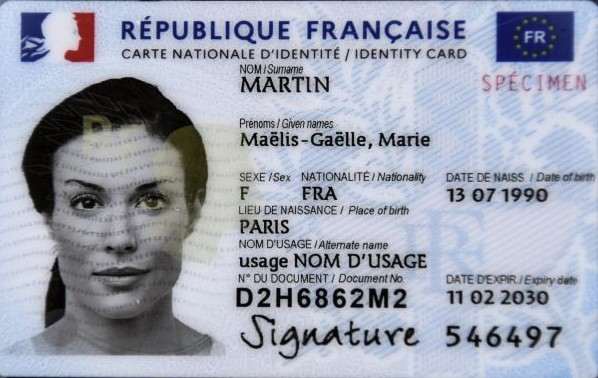

In [17]:
img = Image.open(image_file)
img

In [18]:
analyzer_id = "prebuilt-read"

print(f"🔍 Analyzing '{image_file}' with '{analyzer_id}'...")

response = client.begin_analyze_binary(
    analyzer_id=analyzer_id,
    file_location=image_file,
)

print(f"⏳ Please wait...")
analysis_result = client.poll_result(response)
print(f"✅ Done")

🔍 Analyzing 'documents/id.jpg' with 'prebuilt-read'...
⏳ Please wait...
✅ Done


In [19]:
print("\033[1;31;34m")
print(json.dumps(analysis_result, indent=5))


{
     "id": "c3f5bf74-f38a-4b19-a760-3b5e096f5ff7",
     "status": "Succeeded",
     "result": {
          "analyzerId": "prebuilt-read",
          "apiVersion": "2025-11-01",
          "createdAt": "2025-12-02T13:29:18Z",
          "warnings": [],
          "contents": [
               {
                    "path": "input1",
                    "markdown": "\u05e0\n\nR\u00c9PUBLIQUE FRAN\u00c7AISE\nCARTE NATIONALE D'IDENTIT\u00c9 / IDENTITY CARD\n\nNOM/Sumame\nMARTIN\n\nFR\n\nSP\u00c9CIMEN\n\nPrenoms / Given names\nMa\u0113lis-Ga\u00eblle, Marie\n\nSEXE / Sex NATIONALIT\u00c9 / Nationality\nF\nFRA\n\nDATE DE NAISS / Date of birth\n13 07 1990\n\nLIEU DE NAISSANCE / Place of birth\nPARIS\n\nNOM D'USAGE / Attemate name\n\nusage NOM D'USAGE\n\nN\u00b0 DU DOCUMENT / Document No\nD2H6862M2\n\nDATE D'EXPIR/Expiry date\n11 02 2030\n\nSignature\n\n546497\n",
                    "kind": "document",
                    "startPageNumber": 1,
                    "endPageNumber": 1,
             

In [20]:
print("\033[1;31;34m")
print(analysis_result['result']['contents'][0]['markdown'])


נ

RÉPUBLIQUE FRANÇAISE
CARTE NATIONALE D'IDENTITÉ / IDENTITY CARD

NOM/Sumame
MARTIN

FR

SPÉCIMEN

Prenoms / Given names
Maēlis-Gaëlle, Marie

SEXE / Sex NATIONALITÉ / Nationality
F
FRA

DATE DE NAISS / Date of birth
13 07 1990

LIEU DE NAISSANCE / Place of birth
PARIS

NOM D'USAGE / Attemate name

usage NOM D'USAGE

N° DU DOCUMENT / Document No
D2H6862M2

DATE D'EXPIR/Expiry date
11 02 2030

Signature

546497



## 4. Using `prebuilt-idDocument`

In [21]:
image_file = os.path.join(DOCS_DIR, "driver.jpg")
!ls $image_file -lh

-rwxrwxrwx 1 root root 1.9M Dec  2 12:43 documents/driver.jpg


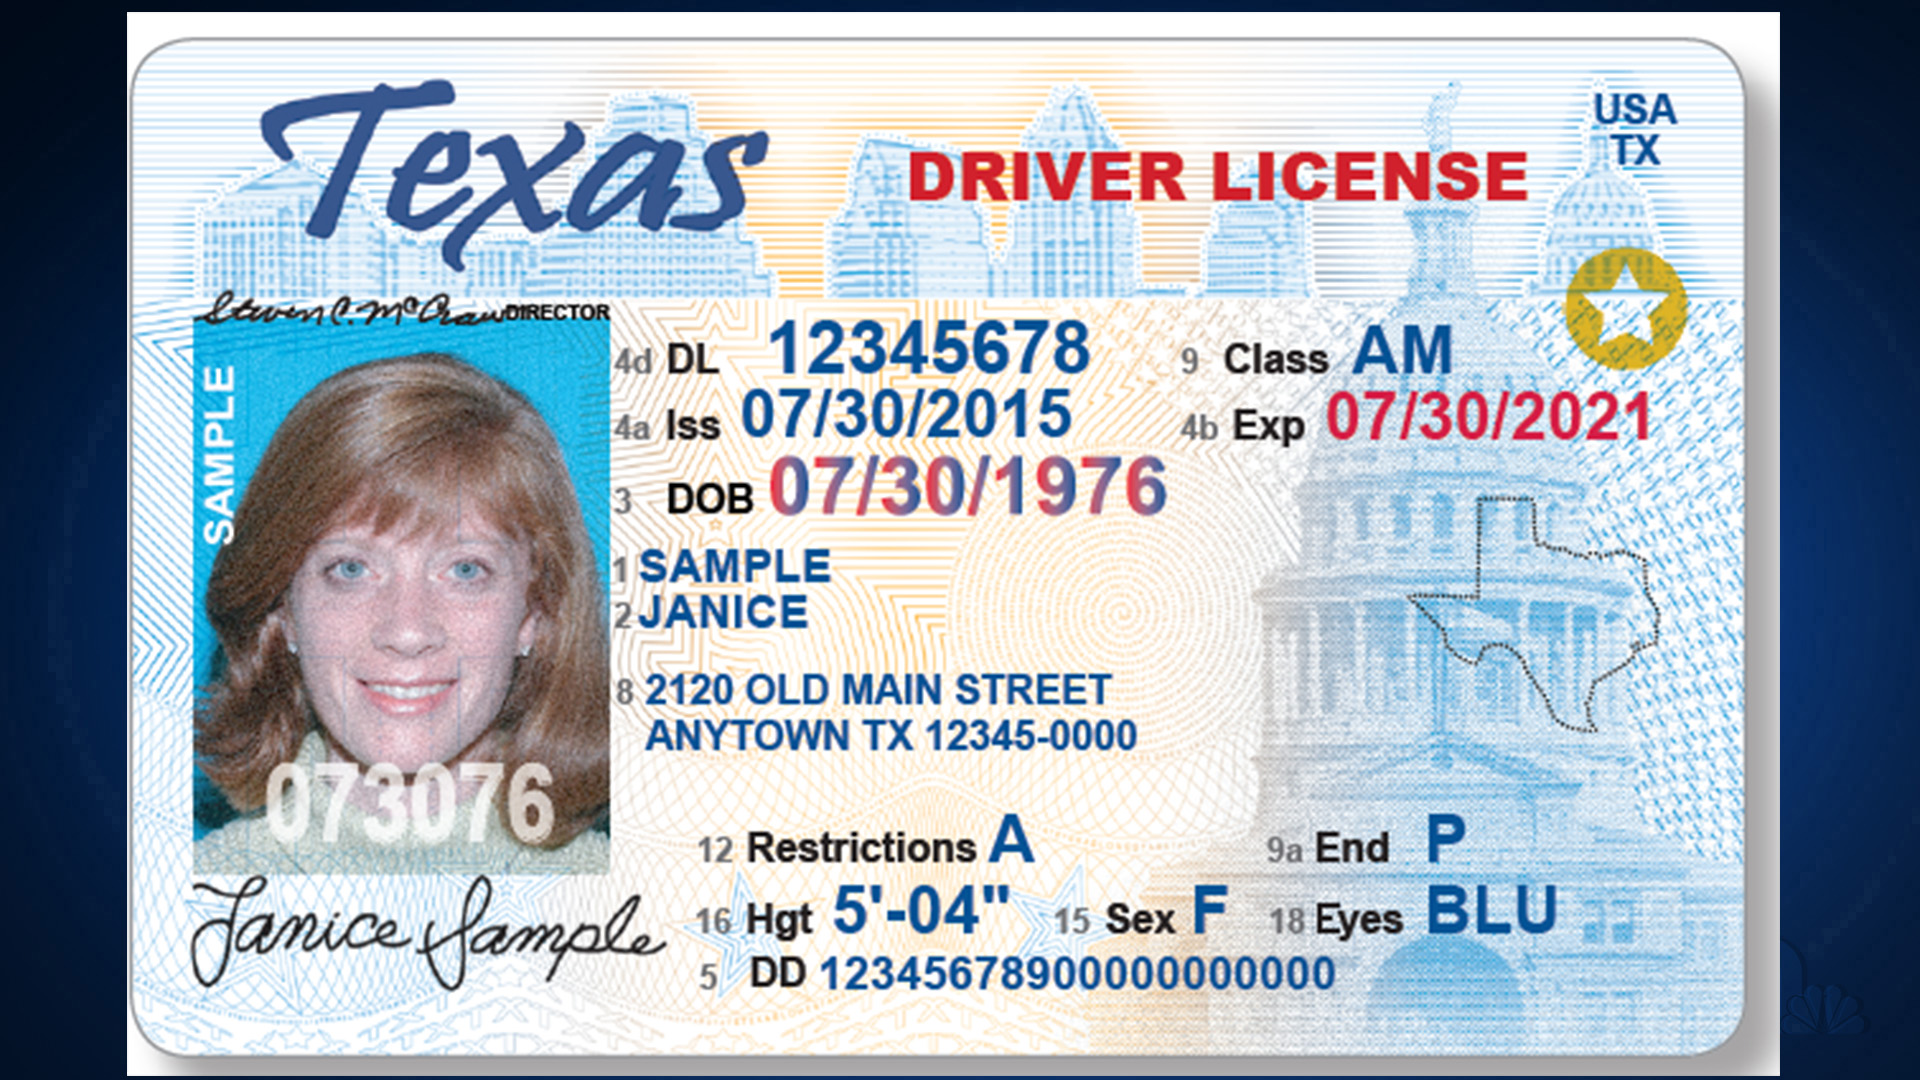

In [22]:
img = Image.open(image_file)
img

In [23]:
analyzer_id = "prebuilt-idDocument"

print(f"🔍 Analyzing '{image_file}' with '{analyzer_id}'...")

response = client.begin_analyze_binary(
    analyzer_id=analyzer_id,
    file_location=image_file,
)

print(f"⏳ Please wait...")
analysis_result = client.poll_result(response)
print(f"✅ Done")

🔍 Analyzing 'documents/driver.jpg' with 'prebuilt-idDocument'...
⏳ Please wait...
✅ Done


In [24]:
print("\033[1;31;34m")
print(json.dumps(analysis_result, indent=5))


{
     "id": "d70d4173-49fb-4f59-adff-970e1a47ceb0",
     "status": "Succeeded",
     "result": {
          "analyzerId": "prebuilt-idDocument",
          "apiVersion": "2025-11-01",
          "createdAt": "2025-12-02T13:29:25Z",
          "warnings": [],
          "contents": [
               {
                    "path": "input1/segment1",
                    "category": "idDocument.generic",
                    "markdown": "Texas\n\n\n# DRIVER LICENSE\n\nltven c. m Chaw DIRECTOR\n\nSAMPLE\n\n073076\n\nJanice Jample\n\n4d DL\n12345678\n9 Class AM\n4b Exp\n07/30/2021\n\n3 DOB\n07/30/1976\n1 SAMPLE\n2 JANICE\n\n8 2120 OLD MAIN STREET\nANYTOWN TX 12345-0000\n\n12 Restrictions A\n\n9a End\nP\n\n16 Hgt\n5'-04\"\n15 Sex F\n18 Eyes BLU\n\n5 DD 12345678900000000000\n\nUSA\nTX\n\n4a Iss\n07/30/2015\n",
                    "fields": {
                         "CountryRegion": {
                              "type": "string",
                              "valueString": "USA"
                 

## 5. Using `prebuilt-layout` on document

In [25]:
document_file = os.path.join(DOCS_DIR, "document.pdf")
!ls $document_file -lh

-rwxrwxrwx 1 root root 260K Nov 27 09:04 documents/document.pdf


In [26]:
analyzer_id = "prebuilt-layout"

print(f"🔍 Analyzing '{document_file}' with '{analyzer_id}'...")

response = client.begin_analyze_binary(
    analyzer_id=analyzer_id,
    file_location=document_file,
)

print(f"⏳ Please wait...")
analysis_result = client.poll_result(response)
print(f"✅ Done")

🔍 Analyzing 'documents/document.pdf' with 'prebuilt-layout'...
⏳ Please wait...
✅ Done


In [27]:
display(Markdown(analysis_result['result']['contents'][0]['markdown']))

CONTOSO LTD.


# INVOICE

Contoso Headquarters
123 456th St
New York, NY, 10001

INVOICE: INV-100

INVOICE DATE: 11/15/2019

DUE DATE: 12/15/2019

CUSTOMER NAME: MICROSOFT CORPORATION

SERVICE PERIOD: 10/14/2019 - 11/14/2019

CUSTOMER ID: CID-12345

Microsoft Corp
123 Other St,
Redmond WA, 98052

BILL TO:
Microsoft Finance
123 Bill St,
Redmond WA, 98052

SHIP TO:
Microsoft Delivery
123 Ship St,
Redmond WA, 98052

SERVICE ADDRESS:
Microsoft Services
123 Service St,
Redmond WA, 98052


<table>
<tr>
<th>SALESPERSON</th>
<th>P.O. NUMBER</th>
<th>REQUISITIONER</th>
<th>SHIPPED VIA</th>
<th>F.O.B. POINT</th>
<th>TERMS</th>
</tr>
<tr>
<td></td>
<td>PO-3333</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
</table>


<table>
<tr>
<th>DATE</th>
<th>ITEM CODE</th>
<th>DESCRIPTION</th>
<th>QTY</th>
<th>UM</th>
<th>PRICE</th>
<th>TAX</th>
<th>AMOUNT</th>
</tr>
<tr>
<td>3/4/2021</td>
<td>A123</td>
<td>Consulting Services</td>
<td>2</td>
<td>hours</td>
<td>$30.00</td>
<td>$6.00</td>
<td>$60.00</td>
</tr>
<tr>
<td>3/5/2021</td>
<td>B456</td>
<td>Document Fee</td>
<td>3</td>
<td></td>
<td>$10.00</td>
<td>$3.00</td>
<td>$30.00</td>
</tr>
<tr>
<td>3/6/2021</td>
<td>C789</td>
<td>Printing Fee</td>
<td>10</td>
<td>pages</td>
<td>$1.00</td>
<td>$1.00</td>
<td>$10.00</td>
</tr>
</table>


<table>
<tr>
<th>SUBTOTAL</th>
<th>$100.00</th>
</tr>
<tr>
<th>SALES TAX</th>
<th>$10.00</th>
</tr>
<tr>
<th>TOTAL</th>
<th>$110.00</th>
</tr>
<tr>
<th>PREVIOUS UNPAID BALANCE</th>
<th>$500.00</th>
</tr>
<tr>
<th>AMOUNT DUE</th>
<th>$610.00</th>
</tr>
</table>


THANK YOU FOR YOUR BUSINESS!

REMIT TO:
Contoso Billing
123 Remit St
New York, NY, 10001

<!-- PageBreak -->


# Contoso Bank

Statement for: John Smith
Account Number: 1234 5678 9012
Statement Period: June 1, 2025 - June 30, 2025


## Account Summary


<table>
<tr>
<th>Beginning Balance</th>
<th>$3,200.00</th>
</tr>
<tr>
<th>Total Deposits</th>
<th>$2,500.00</th>
</tr>
<tr>
<th>Total Withdrawals</th>
<th>$ 650.00</th>
</tr>
<tr>
<th>Ending Balance</th>
<th>$5,050.00</th>
</tr>
</table>


## Transaction History


<table>
<tr>
<th>Date</th>
<th>Description</th>
<th>Withdrawals</th>
<th>Deposits</th>
<th>Balance</th>
</tr>
<tr>
<td>06/01/2025</td>
<td>Opening Balance</td>
<td></td>
<td></td>
<td>$3,200.00</td>
</tr>
<tr>
<td>06/02/2025</td>
<td>Payroll Deposit</td>
<td></td>
<td>$1,200.00</td>
<td>$4,400.00</td>
</tr>
<tr>
<td>06/03/2025</td>
<td>Coffee Shop</td>
<td>$5.75</td>
<td></td>
<td>$4,394.25</td>
</tr>
<tr>
<td>06/05/2025</td>
<td>Online Shopping Company</td>
<td>$89.99</td>
<td></td>
<td>$4,304.26</td>
</tr>
<tr>
<td>06/07/2025</td>
<td>ATM Withdrawal</td>
<td>$100.00</td>
<td></td>
<td>$4,204.26</td>
</tr>
<tr>
<td>06/10/2025</td>
<td>Utility Provider</td>
<td>$145.00</td>
<td></td>
<td>$4,059.26</td>
</tr>
</table>


<!-- PageNumber="Page 1 of 2" -->
<!-- PageBreak -->


## Transaction History (Continued)


<table>
<tr>
<th>Date</th>
<th>Description</th>
<th>Withdrawals</th>
<th>Deposits</th>
<th>Balance</th>
</tr>
<tr>
<td>06/12/2025</td>
<td>Streaming Service</td>
<td>$15.49</td>
<td></td>
<td>$4,043.77</td>
</tr>
<tr>
<td>06/15/2025</td>
<td>Transfer from Savings</td>
<td></td>
<td>$1,300.00</td>
<td>$5,343.77</td>
</tr>
<tr>
<td>06/18/2025</td>
<td>Ride Service</td>
<td>$25.00</td>
<td></td>
<td>$5,318.77</td>
</tr>
<tr>
<td>06/22/2025</td>
<td>Local Restaurant</td>
<td>$80.00</td>
<td></td>
<td>$5,238.77</td>
</tr>
<tr>
<td>06/25/2025</td>
<td>Mobile Provider</td>
<td>$110.00</td>
<td></td>
<td>$5,128.77</td>
</tr>
<tr>
<td>06/28/2025</td>
<td>Gas Station</td>
<td>$53.77</td>
<td></td>
<td>$5,075.00</td>
</tr>
<tr>
<td>06/30/2025</td>
<td>Bank Service Fee</td>
<td>$25.00</td>
<td></td>
<td>$5,050.00</td>
</tr>
</table>


## Notes

For questions about this statement, please contact Contoso Bank Customer Service at (800) 555-
0123 or visit www.contosobank.com.

This is a mock statement for design and testing purposes only. All data is fictitious.

<!-- PageNumber="Page 2 of 2" -->
<!-- PageBreak -->


# Contoso Bank Loan Application Form


## 1. Applicant Information


<table>
<tr>
<th>Full Name:</th>
<th>John Smith</th>
</tr>
<tr>
<th>Date of Birth:</th>
<th>March 14, 1985</th>
</tr>
<tr>
<th>SSN:</th>
<th>123-45-6789</th>
</tr>
<tr>
<th>Phone Number:</th>
<th>(555) 123-4567</th>
</tr>
<tr>
<th>Home Address:</th>
<th>456 Maple Street, Springfield, IL 62704</th>
</tr>
</table>


## 2. Employment Information

Employer:
Contoso Technologies

Job Title:
Software Engineer

Monthly Income (before tax):
$6,500

Employment Length:
5 years


## 3. Loan Details

Loan Amount Requested:
$25,000

Purpose:

Debt Consolidation

Preferred Repayment Term:
36 months


## 4. Consent & Signature

By submitting this application, I certify that all information is accurate and
complete to the best of my knowledge. I authorize Contoso Bank to verify my
credit history and employment status.

Applicant Signature:
John Smith

Date:
July 14, 2025


## 6. Receipt Field Extraction with `prebuilt-receipt`

Let's demonstrate using `prebuilt-receipt` to extract structured data from a receipt image. This analyzer automatically identifies merchant information, items, totals, taxes, and payment details without any configuration.

In [28]:
image_file = os.path.join(DOCS_DIR, "receipt.png")

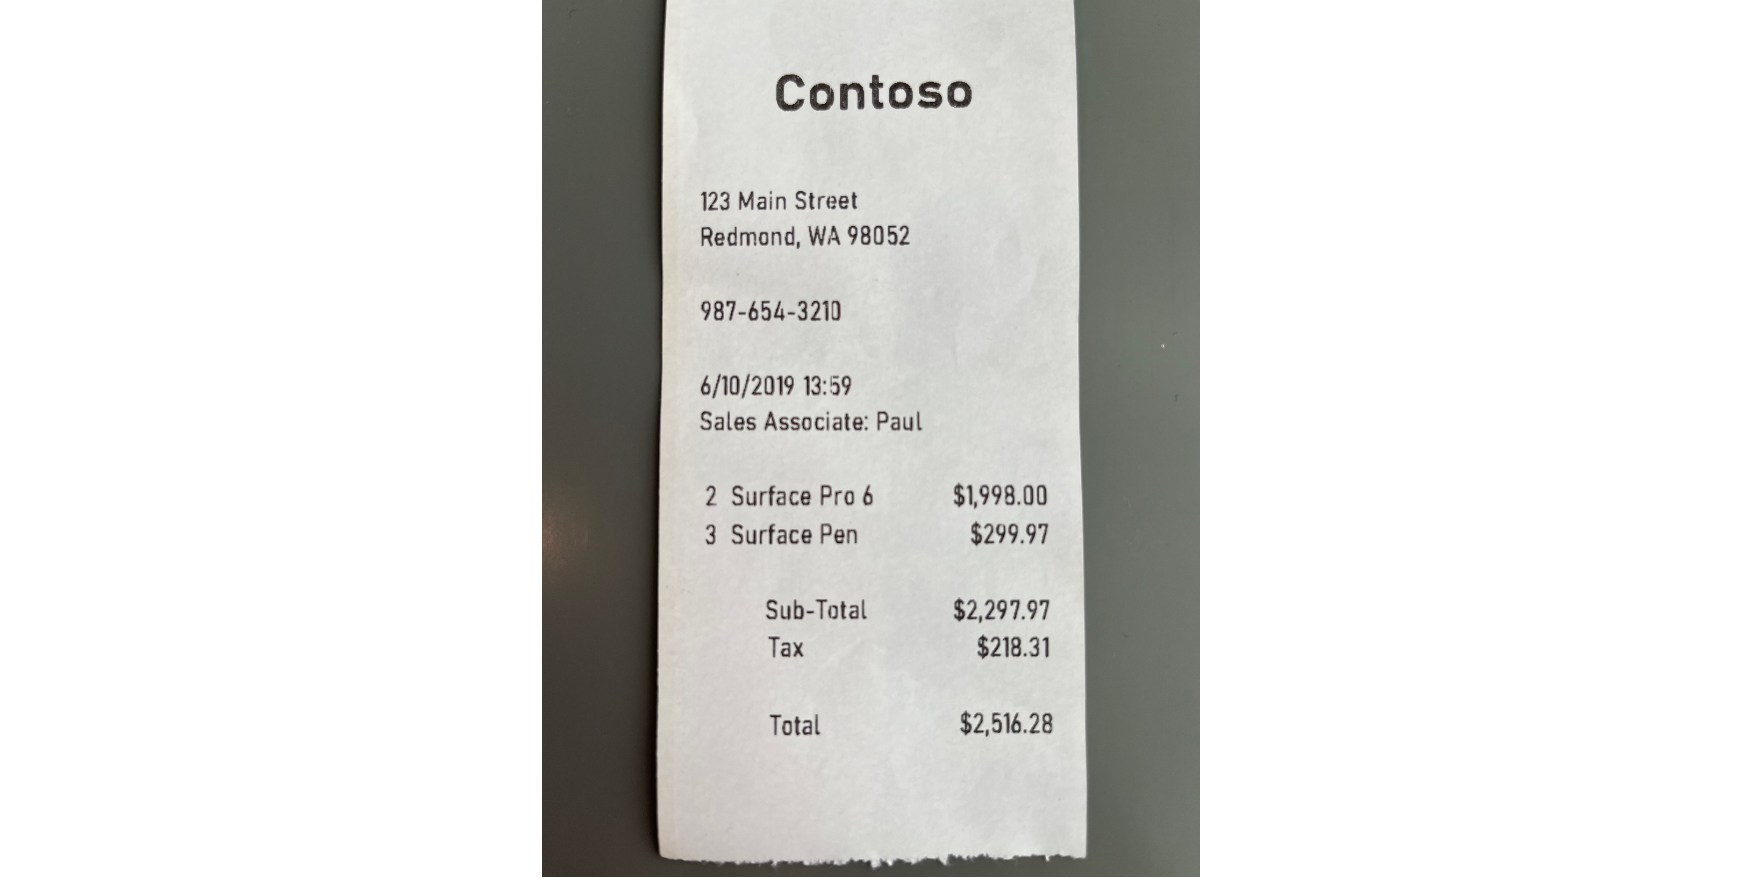

In [29]:
img = Image.open(image_file)
img

In [30]:
analyzer_id = "prebuilt-receipt"

print(f"🔍 Analyzing '{image_file}' with '{analyzer_id}'...")

analysis_response = client.begin_analyze_binary(
    analyzer_id=analyzer_id,
    file_location=image_file,
)

print(f"⏳ Waiting for document analysis to complete...")
analysis_result = client.poll_result(analysis_response)
print(f"✅ Done")

🔍 Analyzing 'documents/receipt.png' with 'prebuilt-receipt'...
⏳ Waiting for document analysis to complete...
✅ Done


In [31]:
print("\033[1;31;34m")
print(json.dumps(analysis_result, indent=5))


{
     "id": "6768cdd9-e31f-4cfa-ad35-26aa5830218b",
     "status": "Succeeded",
     "result": {
          "analyzerId": "prebuilt-receipt",
          "apiVersion": "2025-11-01",
          "createdAt": "2025-12-02T13:29:39Z",
          "warnings": [],
          "contents": [
               {
                    "path": "input1/segment1",
                    "category": "receipt.generic",
                    "markdown": "Contoso\n\n123 Main Street\nRedmond, WA 98052\n\n987-654-3210\n\n6/10/2019 13:59\nSales Associate: Paul\n\n2 Surface Pro 6\n\n$1,998.00\n\n3 Surface Pen\n\n$299.97\n\nSub-Total\n\n$2,297.97\n\nTax\n\n$218.31\n\nTotal\n\n$2,516.28\n",
                    "fields": {
                         "MerchantName": {
                              "type": "string",
                              "valueString": "Contoso",
                              "spans": [
                                   {
                                        "offset": 0,
                              

In [32]:
print("\033[1;31;34m")
print(analysis_result['result']['contents'][0]['markdown'])


Contoso

123 Main Street
Redmond, WA 98052

987-654-3210

6/10/2019 13:59
Sales Associate: Paul

2 Surface Pro 6

$1,998.00

3 Surface Pen

$299.97

Sub-Total

$2,297.97

Tax

$218.31

Total

$2,516.28



In [33]:
def print_section_header(title: str, char: str = "=") -> None:
    """Print a formatted section header"""
    print(f"\n{char * 70}")
    print(f"{title.center(70)}")
    print(f"{char * 70}\n")


def print_subsection(title: str) -> None:
    """Print a formatted subsection header"""
    print(f"\n--- {title} ---")


def format_currency(amount: float, currency: str = "USD") -> str:
    """Format currency amount"""
    symbols = {"USD": "$", "EUR": "€", "GBP": "£"}
    symbol = symbols.get(currency, currency)
    return f"{symbol}{amount:,.2f}"


def display_receipt_analysis(data: Dict[str, Any]) -> None:
    """Display receipt analysis results in a formatted way"""

    # Document status
    print_section_header("📋 DOCUMENT ANALYSIS SUMMARY", "=")
    print(f"Status:           ✅ {data['status']}")
    print(f"Document ID:      {data['id']}")

    result = data['result']
    print(f"Analyzer:         {result['analyzerId']}")
    print(f"API Version:      {result['apiVersion']}")
    print(f"Created:          {result['createdAt']}")

    # Get the first content (receipt)
    content = result['contents'][0]
    fields = content['fields']

    # Merchant Information
    print_section_header("🏪 MERCHANT INFORMATION")

    if 'MerchantName' in fields:
        merchant = fields['MerchantName']
        print(f"Name:             {merchant['valueString']}")
        print(f"                  (confidence: {merchant['confidence']:.1%})")

    if 'MerchantAddress' in fields:
        address = fields['MerchantAddress']
        print(f"Address:          {address['valueString']}")
        print(f"                  (confidence: {address['confidence']:.1%})")

    if 'MerchantPhoneNumber' in fields:
        phone = fields['MerchantPhoneNumber']
        print(f"Phone:            {phone['valueString']}")
        print(f"                  (confidence: {phone['confidence']:.1%})")

    if 'CountryRegion' in fields:
        print(f"Country:          {fields['CountryRegion']['valueString']}")

    # Transaction Information
    print_section_header("📅 TRANSACTION INFORMATION")

    if 'TransactionDate' in fields:
        date_str = fields['TransactionDate']['valueDate']
        date_obj = datetime.fromisoformat(date_str)
        print(f"Date:             {date_obj.strftime('%B %d, %Y')}")
        print(
            f"                  (confidence: {fields['TransactionDate']['confidence']:.1%})"
        )

    if 'TransactionTime' in fields:
        time_str = fields['TransactionTime']['valueTime']
        print(f"Time:             {time_str}")
        print(
            f"                  (confidence: {fields['TransactionTime']['confidence']:.1%})"
        )

    # Line Items
    print_section_header("🛒 ITEMS PURCHASED")

    if 'LineItems' in fields:
        items = fields['LineItems']['valueArray']

        for idx, item in enumerate(items, 1):
            item_obj = item['valueObject']
            print_subsection(f"Item {idx}")

            if 'Description' in item_obj:
                desc = item_obj['Description']
                print(f"  Product:        {desc['valueString']}")
                print(
                    f"                  (confidence: {desc['confidence']:.1%})"
                )

            if 'Quantity' in item_obj:
                qty = item_obj['Quantity']
                print(f"  Quantity:       {int(qty['valueNumber'])}")
                print(
                    f"                  (confidence: {qty['confidence']:.1%})")

            if 'TotalAmount' in item_obj:
                total = item_obj['TotalAmount']['valueObject']
                amount = total['Amount']['valueNumber']
                currency = total['CurrencyCode']['valueString']
                confidence = total['Amount']['confidence']
                print(f"  Total:          {format_currency(amount, currency)}")
                print(f"                  (confidence: {confidence:.1%})")

    # Payment Summary
    print_section_header("💰 PAYMENT SUMMARY")

    # Create summary table
    print(f"{'Description':<20} {'Amount':>15} {'Confidence':>15}")
    print("-" * 50)

    if 'SubtotalAmount' in fields:
        subtotal = fields['SubtotalAmount']['valueObject']
        amount = subtotal['Amount']['valueNumber']
        currency = subtotal['CurrencyCode']['valueString']
        print(f"{'Subtotal':<20} {format_currency(amount, currency):>15}")

    if 'TotalTaxAmount' in fields:
        tax = fields['TotalTaxAmount']['valueObject']
        amount = tax['Amount']['valueNumber']
        currency = tax['CurrencyCode']['valueString']
        print(f"{'Tax':<20} {format_currency(amount, currency):>15}")

    print("-" * 50)

    if 'TotalAmount' in fields:
        total = fields['TotalAmount']['valueObject']
        amount = total['Amount']['valueNumber']
        currency = total['CurrencyCode']['valueString']
        confidence = total['Amount']['confidence']
        print(
            f"{'TOTAL':<20} {format_currency(amount, currency):>15} {confidence:>14.1%}"
        )

    # Tax Details
    if 'TaxDetails' in fields:
        print_subsection("Tax Breakdown")
        tax_details = fields['TaxDetails']['valueArray']
        for tax_item in tax_details:
            tax_obj = tax_item['valueObject']
            if 'Amount' in tax_obj:
                tax_amount = tax_obj['Amount']['valueObject']
                amount = tax_amount['Amount']['valueNumber']
                currency = tax_amount['CurrencyCode']['valueString']
                confidence = tax_amount['Amount']['confidence']
                print(f"  Tax Amount:     {format_currency(amount, currency)}")
                print(f"                  (confidence: {confidence:.1%})")

    # Page Information
    print_section_header("📄 PAGE INFORMATION")

    page = content['pages'][0]
    print(f"Page Number:      {page['pageNumber']}")
    print(f"Dimensions:       {page['width']} x {page['height']} pixels")
    print(f"Angle:            {page['angle']:.4f}°")
    print(f"Words Extracted:  {len(page.get('words', []))}")
    if 'lines' in page:
        print(f"Lines Extracted:  {len(page['lines'])}")

    # Usage Statistics
    print_section_header("📊 USAGE STATISTICS")

    usage = data['usage']
    print(
        f"Pages Processed:  {usage['documentPagesStandard']} standard page(s)")
    print(f"Context Tokens:   {usage['contextualizationTokens']:,}")

    if 'tokens' in usage:
        tokens = usage['tokens']
        print("\nAI Model Tokens:")
        for model, count in tokens.items():
            print(f"  {model:<25} {count:>10,}")

    # Raw Receipt Text
    print_section_header("📝 EXTRACTED TEXT (RAW)")
    print(content['markdown'])

In [34]:
display_receipt_analysis(analysis_result)


                     📋 DOCUMENT ANALYSIS SUMMARY                      

Status:           ✅ Succeeded
Document ID:      6768cdd9-e31f-4cfa-ad35-26aa5830218b
Analyzer:         prebuilt-receipt
API Version:      2025-11-01
Created:          2025-12-02T13:29:39Z

                        🏪 MERCHANT INFORMATION                        

Name:             Contoso
                  (confidence: 59.0%)
Address:          123 Main Street Redmond, WA 98052
                  (confidence: 87.4%)
Phone:            987-654-3210
                  (confidence: 77.0%)
Country:          USA

                      📅 TRANSACTION INFORMATION                       

Date:             June 10, 2019
                  (confidence: 88.3%)
Time:             13:59:00
                  (confidence: 82.7%)

                          🛒 ITEMS PURCHASED                           


--- Item 1 ---
  Product:        Surface Pro 6
                  (confidence: 68.2%)
  Quantity:       2
                  (confidence: 90.

In [35]:
saved_file_path = save_json_to_file(analysis_result, filename_prefix="prebuilt_receipt_analysis_result")

💾 Analysis result saved to: results/prebuilt_receipt_analysis_result_20251202_132947.json


In [36]:
!ls $saved_file_path -lh

-rwxrwxrwx 1 root root 30K Dec  2 13:29 results/prebuilt_receipt_analysis_result_20251202_132947.json


## 7. Using `prebuilt-invoice`

In [37]:
document_file = os.path.join(DOCS_DIR, "invoice.pdf")
!ls $document_file -lh

-rwxrwxrwx 1 root root 148K Dec  2 13:20 documents/invoice.pdf


In [38]:
analyzer_id = "prebuilt-invoice"

print(f"🔍 Analyzing '{document_file}' with '{analyzer_id}'...")

analysis_response = client.begin_analyze_binary(
    analyzer_id=analyzer_id,
    file_location=document_file,
)

print(f"⏳ Waiting for document analysis to complete...")
analysis_result = client.poll_result(analysis_response)
print(f"✅ Done")

🔍 Analyzing 'documents/invoice.pdf' with 'prebuilt-invoice'...
⏳ Waiting for document analysis to complete...
✅ Done


In [39]:
print("\033[1;31;34m")
print(json.dumps(analysis_result, indent=5))


{
     "id": "0661a0a4-488c-46a1-ba48-ccba040f1f6b",
     "status": "Succeeded",
     "result": {
          "analyzerId": "prebuilt-invoice",
          "apiVersion": "2025-11-01",
          "createdAt": "2025-12-02T13:29:48Z",
          "warnings": [],
          "contents": [
               {
                    "path": "input1",
                    "markdown": "CONTOSO LTD.\n\n\n# INVOICE\n\nContoso Headquarters\n123 456th St\nNew York, NY, 10001\n\nINVOICE: INV-100\n\nINVOICE DATE: 11/15/2019\n\nDUE DATE: 12/15/2019\n\nCUSTOMER NAME: MICROSOFT CORPORATION\n\nSERVICE PERIOD: 10/14/2019 - 11/14/2019\n\nCUSTOMER ID: CID-12345\n\nMicrosoft Corp\n123 Other St,\nRedmond WA, 98052\n\nBILL TO:\nMicrosoft Finance\n123 Bill St,\nRedmond WA, 98052\n\nSHIP TO:\nMicrosoft Delivery\n123 Ship St,\nRedmond WA, 98052\n\nSERVICE ADDRESS:\nMicrosoft Services\n123 Service St,\nRedmond WA, 98052\n\n\n<table>\n<tr>\n<th>SALESPERSON</th>\n<th>P.O. NUMBER</th>\n<th>REQUISITIONER</th>\n<th>SHIPPED VIA</th>\

In [40]:
saved_file_path = save_json_to_file(analysis_result, filename_prefix="prebuilt_invoice_result")

💾 Analysis result saved to: results/prebuilt_invoice_result_20251202_133006.json


In [41]:
!ls $saved_file_path -lh

-rwxrwxrwx 1 root root 153K Dec  2 13:30 results/prebuilt_invoice_result_20251202_133006.json
